In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (roc_auc_score, average_precision_score,
                           roc_curve, precision_recall_curve,
                           confusion_matrix, classification_report)
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


In [69]:
import anndata as ad
ppmi_ad = ad.read_h5ad("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/ppmi_adata.h5ad")

In [70]:
borda_features = pd.read_csv("/Users/kpax/Documents/aep/study/MSC/lab/PPMI_Project_133_RNASeq/feature_selection/borda_ranks_Male_30-50.csv", index_col=0)

In [71]:
borda_features.head()

,BL,V02,V04,V06,V08
Gene,,,,,
ENSG00000000003.14,12853.0,12469.0,NaN,4269.0,NaN
ENSG00000000005.5,NaN,NaN,NaN,NaN,199.0
ENSG00000000419.12,NaN,NaN,9134.0,13463.0,NaN
ENSG00000000457.13,NaN,7924.0,NaN,NaN,NaN
ENSG00000000938.12,NaN,NaN,NaN,NaN,11082.0


In [72]:
greatest_rank = borda_features[['BL', 'V02', 'V04', 'V06', 'V08']].max().max()
lowest_rank = borda_features[['BL', 'V02', 'V04', 'V06', 'V08']].min().min()

print("Greatest value:", greatest_rank)
print("Lowest value:", lowest_rank)

Greatest value: 15838.0
Lowest value: 1.0


In [73]:
features_detected_in_all_visits = borda_features.dropna(how='any')
features_detected_in_all_visits

,BL,V02,V04,V06,V08
Gene,,,,,
ENSG00000013293.5,13912.0,12515.0,8286.0,12316.0,9604.0
ENSG00000049247.13,295.0,11492.0,13326.0,14311.0,11869.0
ENSG00000089012.14,14571.0,13686.0,11710.0,12526.0,5961.0
ENSG00000099326.8,6820.0,2541.0,7142.0,2950.0,11236.0
ENSG00000103351.12,11249.0,10222.0,5295.0,2095.0,7289.0
...,...,...,...,...,...
ENSG00000275631.1,9841.0,5156.0,6226.0,9173.0,9751.0
ENSG00000277704.1,2495.0,4828.0,11398.0,2155.0,10605.0
ENSG00000283232.1,4872.0,3701.0,7452.0,4209.0,1383.0


In [74]:
bl_non_nan_values = borda_features['BL'].dropna().sort_values(ascending=False)
bl_non_nan_values

Gene
ENSG00000234848.1     14873.0
ENSG00000279853.1     14872.0
ENSG00000248796.1     14871.0
ENSG00000250242.1     14870.0
ENSG00000100505.13    14869.0
                       ...   
ENSG00000226765.1         5.0
ENSG00000257434.1         4.0
ENSG00000251707.2         3.0
ENSG00000204382.11        2.0
ENSG00000254852.8         1.0
Name: BL, Length: 14873, dtype: float64

In [75]:
top_bl_non_nan_values = bl_non_nan_values[bl_non_nan_values > 10000]

In [76]:
mask = ((ppmi_ad.obs['Age_Group'] == '30-50') &
        (ppmi_ad.obs['Gender'] == 'Male') &
        (ppmi_ad.obs['Diagnosis'].isin(['PD', 'Control'])) &
        (ppmi_ad.obs['Visit'] == 'BL'))

In [77]:
ppmi_ad = ppmi_ad[mask]

In [78]:
ppmi_ad = ppmi_ad[:, ppmi_ad.var.index.isin(top_bl_non_nan_values.index)]

In [79]:
X = pd.DataFrame(ppmi_ad.layers['counts_log2'], columns=ppmi_ad.var_names)
y = (ppmi_ad.obs['Diagnosis'] == 'PD').astype(int)

In [80]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [81]:
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('lr', LogisticRegression(
        class_weight='balanced',
        max_iter=1000,
        random_state=42
    ))
])

In [82]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'lr__C': np.logspace(-3, 3, 7),
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear'],
    'smote__k_neighbors': [3, 5]
}

grid_search = GridSearchCV(
    lr_pipeline,
    param_grid,
    cv=StratifiedKFold(10),
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)
best_lr = grid_search.best_estimator_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


In [83]:
best_lr.named_steps['lr'].get_params()

{'C': np.float64(1000.0),
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [84]:
best_lr.fit(X_train, y_train)
y_pred = best_lr.predict(X_test)
y_proba = best_lr.predict_proba(X_test)[:,1]

In [85]:
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.33      0.50      0.40         4
           1       0.50      0.33      0.40         6

    accuracy                           0.40        10
   macro avg       0.42      0.42      0.40        10
weighted avg       0.43      0.40      0.40        10



In [86]:
print(f"\nROC-AUC: {roc_auc_score(y_test, y_proba):.3f}")
print(f"PR-AUC: {average_precision_score(y_test, y_proba):.3f}")


ROC-AUC: 0.375
PR-AUC: 0.566


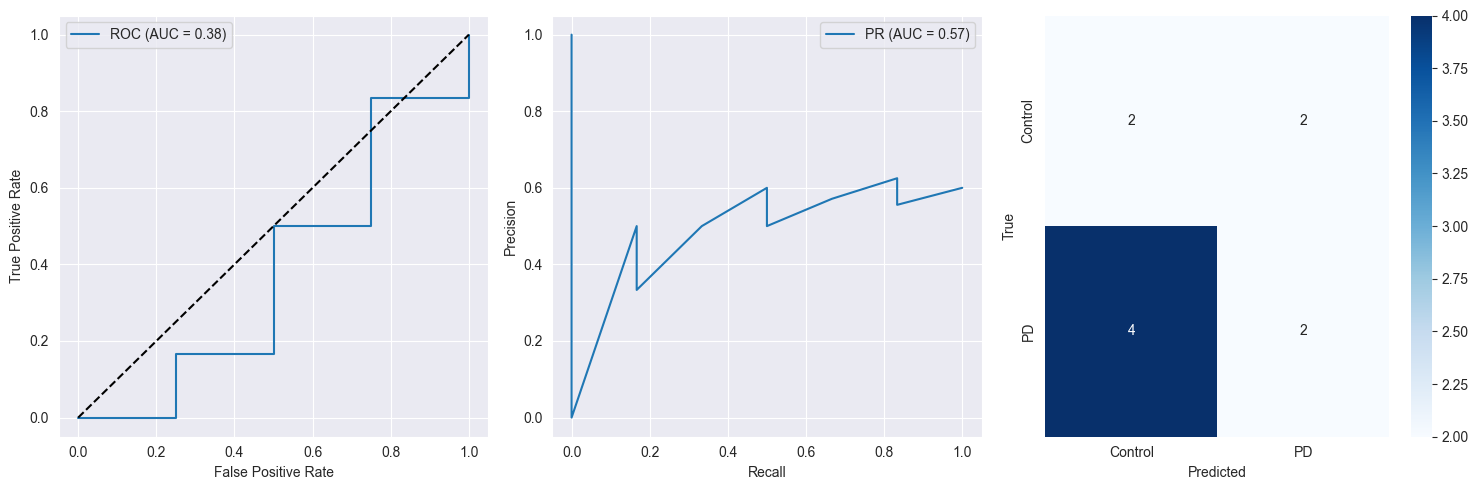

In [87]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
fpr, tpr, roc_threshold = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y_test, y_proba):.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

plt.subplot(1, 3, 2)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)
plt.plot(recall, precision, label=f'PR (AUC = {average_precision_score(y_test, y_proba):.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

plt.subplot(1, 3, 3)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Control', 'PD'],
            yticklabels=['Control', 'PD'])
plt.xlabel('Predicted')
plt.ylabel('True')

plt.tight_layout()
plt.show()

In [88]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = {'roc_auc': [], 'pr_auc': []}

for train_idx, val_idx in cv.split(X, y):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    lr_pipeline.fit(X_train, y_train)
    y_proba = lr_pipeline.predict_proba(X_val)[:, 1]

    cv_scores['roc_auc'].append(roc_auc_score(y_val, y_proba))
    cv_scores['pr_auc'].append(average_precision_score(y_val, y_proba))

print("\nCross-validation results:")
print(f"ROC-AUC: {np.mean(cv_scores['roc_auc']):.3f} ± {np.std(cv_scores['roc_auc']):.3f}")
print(f"PR-AUC: {np.mean(cv_scores['pr_auc']):.3f} ± {np.std(cv_scores['pr_auc']):.3f}")



Cross-validation results:
ROC-AUC: 0.500 ± 0.333
PR-AUC: 0.769 ± 0.156
